### Measuring Ground Reaction Forces, Center of Pressure, and Abductor/Adductor Muscle Activation from Variable Landing Heights and Foot Spacings

This project examines the ground reaction forces, center of pressure, and the muscle activation patterns of the abductor/adductor muscles when landing from two different heights (30.48cm and 60.96cm) using three different foot spacings (20cm, 40cm, and 60cm). Three trials were conducted for each landing height/foot spacing combination resulting in 18 total trials. Three of the trials (height 30.48cm/spacing 20cm/trial 2; height 30.48cm/spacing 60cm/trial 1; height 60.96cm/spacing 40cm/trial 1) were discarded due to data collection errors. Only data from the right leg is examined.

In [1]:
# import libraries
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_axes_aligner import align
from scipy import signal
from scipy.interpolate import interp1d

Create a Time Normalization function, a Fourth Order Zero-Lag Butterworth Filter, and a Rectified EMG function to assist with data processing. 

In [2]:
# create a function that normalizes the length of a vector using interpolation
def time_norm(vec, new_length=100):
    '''
    Normalizes the length of a vector to the desired number
    of data points using interpolation.
    
    Args:
        vec - an array of numeric data representing the results
              of some function over time
    
    Returns:
        an interpolated array of data where len(array) = new_length
    '''
    # length of original vector
    n = len(vec)
    
    # original time vector
    t0 = np.linspace(0, n - 1, n)
    
    # new time vector
    t1 = np.linspace(0, n - 1, new_length)
    
    # interpolation
    f = interp1d(t0, vec, kind='cubic')
    
    return f(t1)

In [3]:
# create a Forth Order Zero-Lag Butterworth filter
def bw_filter(vec, freq_cutoff, freq_sample_rate, filter_type='Low'):
    '''
    Implements an 4th Order Zero-Lag Butterworth filter.
    
    Args:
        vec - an array of data
        freq_cutoff - the cutoff frequency
        freq_sample_rate - the sampling rate of the input data
        filter_type - {‘lowpass’, ‘highpass’, ‘bandpass’, ‘bandstop’}
    
    Returns:
        a filtered array of data
    '''
    # calculate Wn
    wn = 2 * freq_cutoff / freq_sample_rate
    
    # calculate the Butterworth coefficients
    b, a = signal.butter(2, wn, btype=filter_type)
    
    return signal.filtfilt(b, a, vec)

In [4]:
# create a function to rectify the EMG data
def rectified_emg(vec, low_freq_cutoff=400, high_freq_cutoff=10, freq_sample_rate=1000):
    '''
    Rectifies a raw EMG signal.
    
    Args:
        vec - an array of raw EMG data
        low_freq_cutoff - the lowpass filter ceiling
        high_freq_cutoff - the highpass filter floor
        freq_sample_rate - the sampling rate of the input data
        
    Returns:
        a rectified EMG signal
    '''
    # lowpass filter
    filtered = bw_filter(vec, low_freq_cutoff, freq_sample_rate, filter_type='Low')
    
    # highpass filter
    filtered = bw_filter(filtered, high_freq_cutoff, freq_sample_rate, filter_type='High')
    
    # take the absolute value
    filtered = abs(filtered)
    
    return filtered

Load all the trials into a single dataframe and trim each trial so that the first observation begins 500ms before impact and the last observation ends 1000ms after impact.

In [5]:
# get all the file names in the data directory
file_names = glob.glob("./data/*.csv")

In [6]:
# load and parse all of the data files for the desired data
dataframes = []

for name in file_names:
    print("Loading:", name)
    # load force plate data
    fp_data = pd.read_csv(name, header=None, skiprows=5, on_bad_lines='skip')

    # drop extra rows after force plate data
    drop_num_rows = sum(fp_data.iloc[:, 1].isna())
    fp_data = fp_data.iloc[:-drop_num_rows]

    # keep only the desired columns
    fp_data = fp_data.iloc[:, [0, 1, 13, 18, 24, 31]]

    # change the first column to the correct data type
    fp_data.iloc[:, 0] = fp_data.iloc[:, 0].astype(int)

    # load angle data
    skip_num_rows = 5 + fp_data.shape[0] + drop_num_rows + 2
    get_num_rows = int(fp_data.iloc[-1][0])
    angle_data = pd.read_csv(name, header=None, skiprows=skip_num_rows, nrows=get_num_rows)

    # keep only the desired columns
    angle_data = angle_data.iloc[:, [0, 155]]

    # merge the two dataframes
    full_data = pd.merge(fp_data, angle_data, how='left', on=0)

    # rename the columns
    col_names = {0: "frame",
                 1: "subframe",
                 13: "fz_right",
                 18: "cop_y_right",
                 24: "adductor_right",
                 31: "abductor_right",
                 155: "knee_angle_right"}
    full_data = full_data.rename(columns=col_names)
    
    # trim the trial so that the first observation is at impact minus 500ms
    # and the last observation is at impact plus 1000ms
    impact_index = np.nonzero(full_data.fz_right.values)[0][0]
    start_index = impact_index - 500
    end_index = impact_index + 1000
    full_data = full_data.iloc[start_index:end_index, :]
    
    # compute the CoP medial/lateral displacement
    cop_y_default = 766
    first_cop_reading = full_data.cop_y_right.iloc[np.nonzero(full_data.cop_y_right.values != cop_y_default)[0][0]]
    cop_y_displacement = full_data.cop_y_right
    cop_y_displacement.loc[cop_y_displacement == cop_y_default] = 0
    cop_y_displacement.loc[cop_y_displacement != 0] = cop_y_displacement.loc[cop_y_displacement != 0] - first_cop_reading
    full_data["cop_y_displacement"] = cop_y_displacement
    
    # rectify the EMG data
    full_data.abductor_right = rectified_emg(full_data.abductor_right.values)
    full_data.adductor_right = rectified_emg(full_data.adductor_right.values)
    
    # add columns for landing height, foot spacing, and trial number
    full_data["height"] = int(name[7:9])
    full_data.height = full_data.height.map(lambda x: 30 if x == 12 else 60)
    full_data["spacing"] = int(name[13:15])
    full_data["trial"] = int(name[16:18])
    
    # append the resultant dataframe to the list of dataframes
    dataframes.append(full_data)

# combine all the trials into one dataframe
all_trials = pd.concat(dataframes, ignore_index=True)

Loading: ./data\12Jump20_01.csv
Loading: ./data\12Jump20_03.csv
Loading: ./data\12Jump40_01.csv
Loading: ./data\12Jump40_02.csv


C:\Users\dlpar\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Loading: ./data\12Jump40_03.csv
Loading: ./data\12Jump60_02.csv
Loading: ./data\12Jump60_03.csv
Loading: ./data\24Jump20_01.csv
Loading: ./data\24Jump20_02.csv
Loading: ./data\24Jump20_03.csv
Loading: ./data\24Jump40_02.csv
Loading: ./data\24Jump40_03.csv
Loading: ./data\24Jump60_01.csv
Loading: ./data\24Jump60_02.csv
Loading: ./data\24Jump60_03.csv


Drop the frame and subframe columns, reorder the columns, change the vertical forces to positive values, and compute the rate of force development.

In [7]:
# reorder the columns
new_order = ['height', 'spacing', 'trial', 'fz_right', 'knee_angle_right',
             'cop_y_displacement', 'abductor_right', 'adductor_right']
all_trials = all_trials[new_order]

# change the forces from negative to positive values
all_trials.fz_right = abs(all_trials.fz_right)

# calculate the rate of force development
all_trials["fz_right_rfd"] = np.gradient(all_trials.fz_right)

#### Analyze the data.

In [8]:
# get the peaks for each trial
all_trials.groupby(by=['height', 'spacing', 'trial']).max()

fz_right  knee_angle_right  cop_y_displacement  \
height spacing trial                                                   
30     20      1       1671.03           65.6433              13.374   
               3       2240.51           68.1842               2.834   
       40      1       1433.51           70.8395              19.759   
               2       1839.54           71.5951              13.763   
               3       1768.08           71.2369               2.116   
       60      2       2014.75           84.0410              27.667   
               3       1543.20           79.7797              26.990   
60     20      1       2305.11           87.0824              22.169   
               2       1908.85           95.5598               0.737   
               3       1870.50           88.4779               0.000   
       40      2       2356.37           89.9473               0.000   
               3       2210.52           95.2986              22.773   
       60      1       2331.83           94.8120              20.689   
               2       2506.14           96.3913              13.093   
               3       2271.77           95.7741              36.777   

                      abductor_right  adductor_right  fz_right_rfd  
height spacing trial                                                
30     20      1            0.824704        1.221104       85.5650  
               3            0.836673        1.204079      153.3750  
       40      1            0.206529        0.330697       68.8800  
               2            0.598727        0.294902      114.5750  
               3            0.851204        0.320497       75.5600  
       60      2            0.306354        0.194371      180.2300  
               3            0.247019        0.320422      105.3415  
60     20      1            0.159334        1.274498      159.2845  
               2            0.217735        0.876802      143.5755  
               3            0.241820        1.221110      112.7980  
       40      2            0.998216        0.312999      144.3200  
               3            1.094031        0.314123      143.2450  
       60      1            0.373568        0.316173      171.4920  
               2            1.496449        0.201991      156.2500  
               3            0.247235        0.211629      162.1700

In [9]:
# get the peaks for each landing height/foot spacing combination
all_trials.groupby(by=['height', 'spacing']).max().iloc[:, 1:]

fz_right  knee_angle_right  cop_y_displacement  \
height spacing                                                   
30     20        2240.51           68.1842              13.374   
       40        1839.54           71.5951              19.759   
       60        2014.75           84.0410              27.667   
60     20        2305.11           95.5598              22.169   
       40        2356.37           95.2986              22.773   
       60        2506.14           96.3913              36.777   

                abductor_right  adductor_right  fz_right_rfd  
height spacing                                                
30     20             0.836673        1.221104      153.3750  
       40             0.851204        0.330697      114.5750  
       60             0.306354        0.320422      180.2300  
60     20             0.241820        1.274498      159.2845  
       40             1.094031        0.314123      144.3200  
       60             1.496449        0.316173      171.4920

#### Plot the data.

Ground Reaction Forces (GRFs)

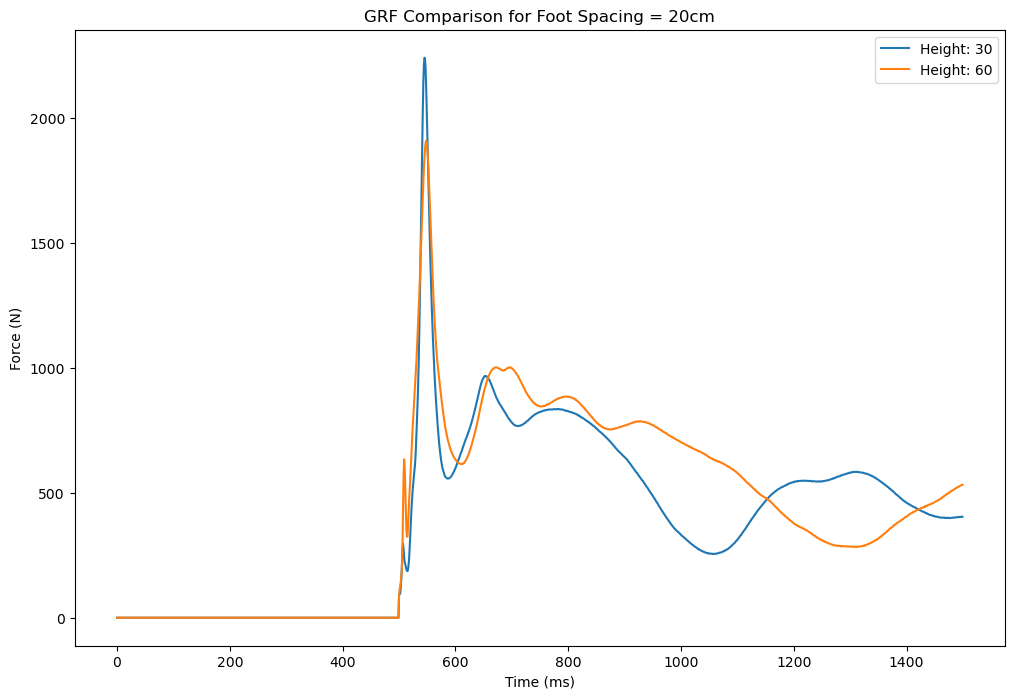

In [10]:
# GRF for spacing = 20
# filter data for height = 30
height = 30
spacing = 20
trial = 3
filt1 = (all_trials.height == height) & (all_trials.spacing == spacing) & (all_trials.trial == trial)

# filter data for height = 60
height = 60
spacing = 20
trial = 2
filt2 = (all_trials.height == height) & (all_trials.spacing == spacing) & (all_trials.trial == trial)

# plot both samples on same plot
plt.figure(figsize=(12, 8))
plt.plot(all_trials.loc[filt1].fz_right.reset_index(drop=True), label="Height: 30")
plt.plot(all_trials.loc[filt2].fz_right.reset_index(drop=True), label="Height: 60")
plt.xlabel("Time (ms)")
plt.ylabel("Force (N)")
plt.title("GRF Comparison for Foot Spacing = {}cm".format(spacing))
plt.legend()
plt.show();

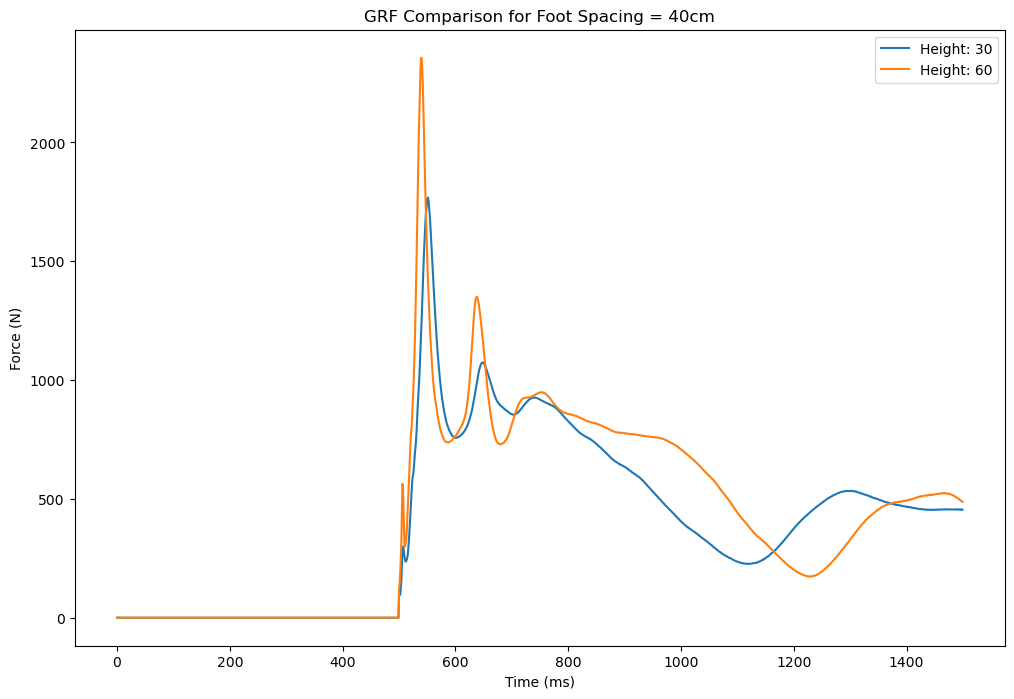

In [11]:
# GRF for spacing = 40
# filter data for height = 30
height = 30
spacing = 40
trial = 3
filt1 = (all_trials.height == height) & (all_trials.spacing == spacing) & (all_trials.trial == trial)

# filter data for height = 60
height = 60
spacing = 40
trial = 2
filt2 = (all_trials.height == height) & (all_trials.spacing == spacing) & (all_trials.trial == trial)

# plot both samples on same plot
plt.figure(figsize=(12, 8))
plt.plot(all_trials.loc[filt1].fz_right.reset_index(drop=True), label="Height: 30")
plt.plot(all_trials.loc[filt2].fz_right.reset_index(drop=True), label="Height: 60")
plt.xlabel("Time (ms)")
plt.ylabel("Force (N)")
plt.title("GRF Comparison for Foot Spacing = {}cm".format(spacing))
plt.legend()
plt.show();

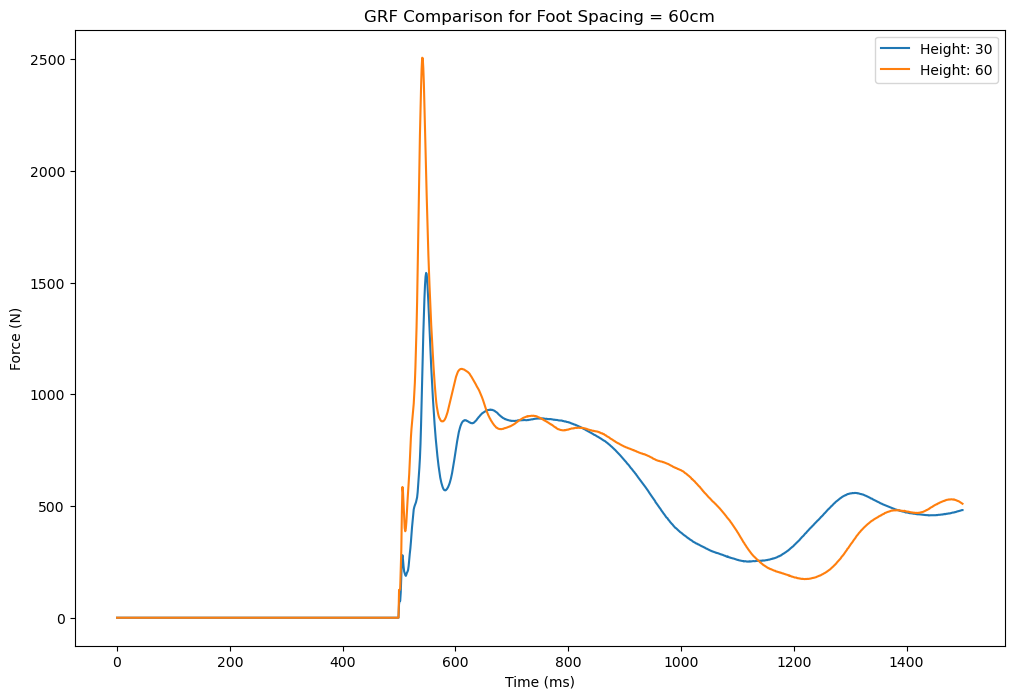

In [12]:
# GRF for spacing = 60
# filter data for height = 30
height = 30
spacing = 60
trial = 3
filt1 = (all_trials.height == height) & (all_trials.spacing == spacing) & (all_trials.trial == trial)

# filter data for height = 60
height = 60
spacing = 60
trial = 2
filt2 = (all_trials.height == height) & (all_trials.spacing == spacing) & (all_trials.trial == trial)

# plot both samples on same plot
plt.figure(figsize=(12, 8))
plt.plot(all_trials.loc[filt1].fz_right.reset_index(drop=True), label="Height: 30")
plt.plot(all_trials.loc[filt2].fz_right.reset_index(drop=True), label="Height: 60")
plt.xlabel("Time (ms)")
plt.ylabel("Force (N)")
plt.title("GRF Comparison for Foot Spacing = {}cm".format(spacing))
plt.legend()
plt.show();

Center of Pressure (CoP) displacement and Abductor/Adductor activation.  

The data have been modified such that negative CoP displacement indicates movement away from the lateral side of the right leg and the abductor/adductor EMG data have been multiplied by 10 to enhance readability on the plot.

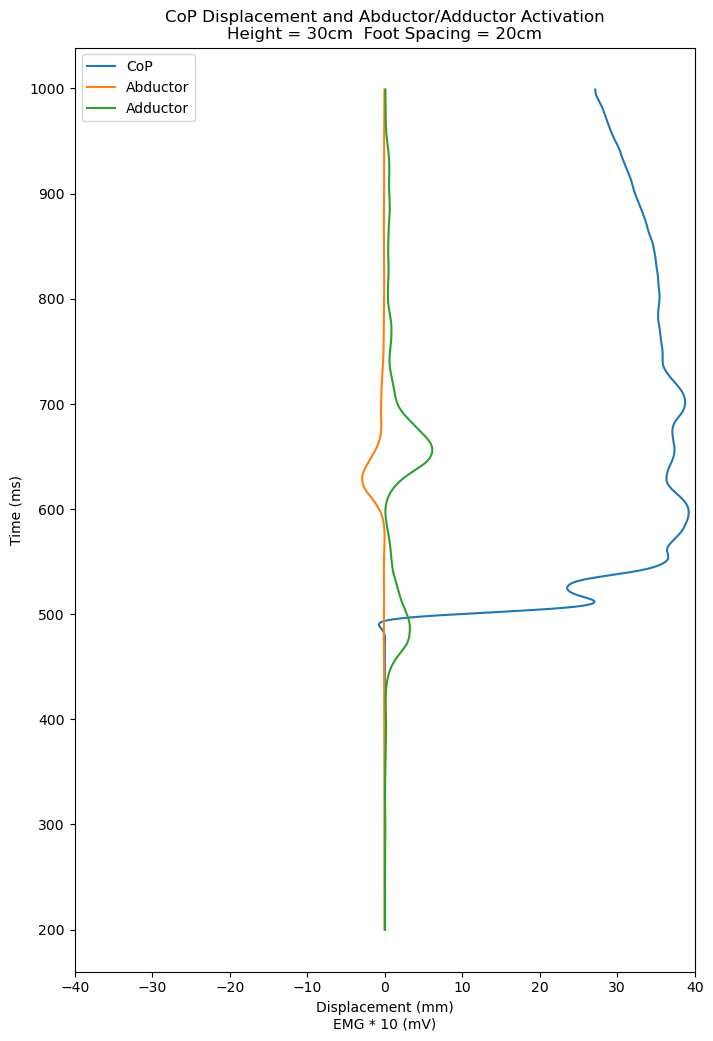

In [13]:
# filter data for height = 30 and spacing = 20
height = 30
spacing = 20
trial = 3
filt1 = (all_trials.height == height) & (all_trials.spacing == spacing) & (all_trials.trial == trial)

# plot CoP and abductor/adductor EMG on same plot
plt.figure(figsize=(8, 12))
filtered_cop = bw_filter(all_trials.loc[filt1].cop_y_displacement.values, 50, 1000)
y = np.linspace(0, len(filtered_cop) - 1, len(filtered_cop))
plt.plot(-filtered_cop[200:1000], y[200:1000], label="CoP")
filtered_abd = bw_filter(all_trials.loc[filt1].abductor_right.values, 15, 1000)
plt.plot(filtered_abd[200:1000] * -10, y[200:1000], label="Abductor")
filtered_add = bw_filter(all_trials.loc[filt1].adductor_right.values, 15, 1000)
plt.plot(filtered_add[200:1000] * 10, y[200:1000], label="Adductor")
plt.xlabel("Displacement (mm)\nEMG * 10 (mV)")
plt.ylabel("Time (ms)")
plt.xlim(-40, 40)
plt.title("CoP Displacement and Abductor/Adductor Activation\nHeight = {}cm  Foot Spacing = {}cm".format(height, spacing))
plt.legend()
plt.show();

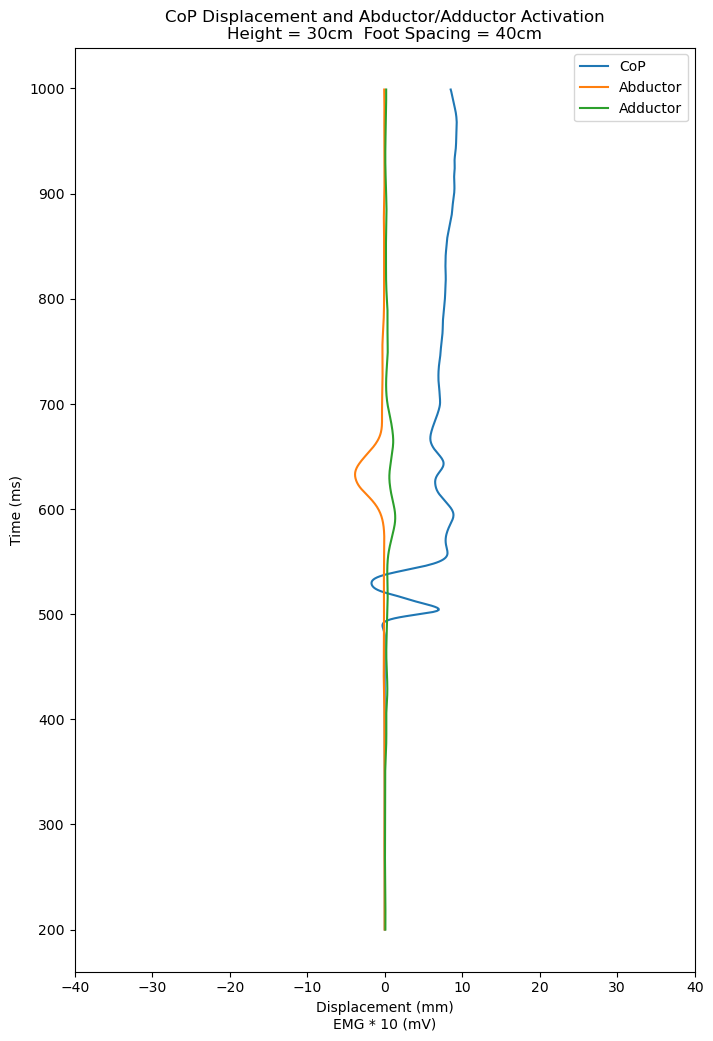

In [14]:
# filter data for height = 30 and spacing = 40
height = 30
spacing = 40
trial = 3
filt1 = (all_trials.height == height) & (all_trials.spacing == spacing) & (all_trials.trial == trial)

# plot CoP and abductor/adductor EMG on same plot
plt.figure(figsize=(8, 12))
filtered_cop = bw_filter(all_trials.loc[filt1].cop_y_displacement.values, 50, 1000)
y = np.linspace(0, len(filtered_cop) - 1, len(filtered_cop))
plt.plot(-filtered_cop[200:1000], y[200:1000], label="CoP")
filtered_abd = bw_filter(all_trials.loc[filt1].abductor_right.values, 15, 1000)
plt.plot(filtered_abd[200:1000] * -10, y[200:1000], label="Abductor")
filtered_add = bw_filter(all_trials.loc[filt1].adductor_right.values, 15, 1000)
plt.plot(filtered_add[200:1000] * 10, y[200:1000], label="Adductor")
plt.xlabel("Displacement (mm)\nEMG * 10 (mV)")
plt.ylabel("Time (ms)")
plt.xlim(-40, 40)
plt.title("CoP Displacement and Abductor/Adductor Activation\nHeight = {}cm  Foot Spacing = {}cm".format(height, spacing))
plt.legend()
plt.show();

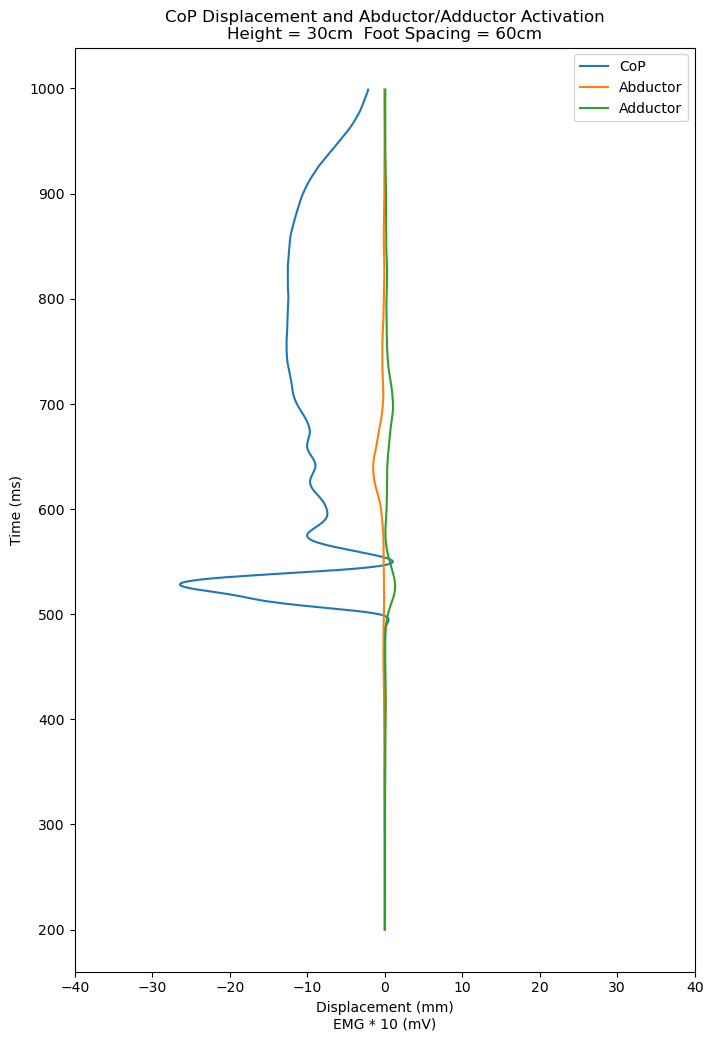

In [15]:
# filter data for height = 30 and spacing = 60
height = 30
spacing = 60
trial = 3
filt1 = (all_trials.height == height) & (all_trials.spacing == spacing) & (all_trials.trial == trial)

# plot CoP and abductor/adductor EMG on same plot
plt.figure(figsize=(8, 12))
filtered_cop = bw_filter(all_trials.loc[filt1].cop_y_displacement.values, 50, 1000)
y = np.linspace(0, len(filtered_cop) - 1, len(filtered_cop))
plt.plot(-filtered_cop[200:1000], y[200:1000], label="CoP")
filtered_abd = bw_filter(all_trials.loc[filt1].abductor_right.values, 15, 1000)
plt.plot(filtered_abd[200:1000] * -10, y[200:1000], label="Abductor")
filtered_add = bw_filter(all_trials.loc[filt1].adductor_right.values, 15, 1000)
plt.plot(filtered_add[200:1000] * 10, y[200:1000], label="Adductor")
plt.xlabel("Displacement (mm)\nEMG * 10 (mV)")
plt.ylabel("Time (ms)")
plt.xlim(-40, 40)
plt.title("CoP Displacement and Abductor/Adductor Activation\nHeight = {}cm  Foot Spacing = {}cm".format(height, spacing))
plt.legend()
plt.show();

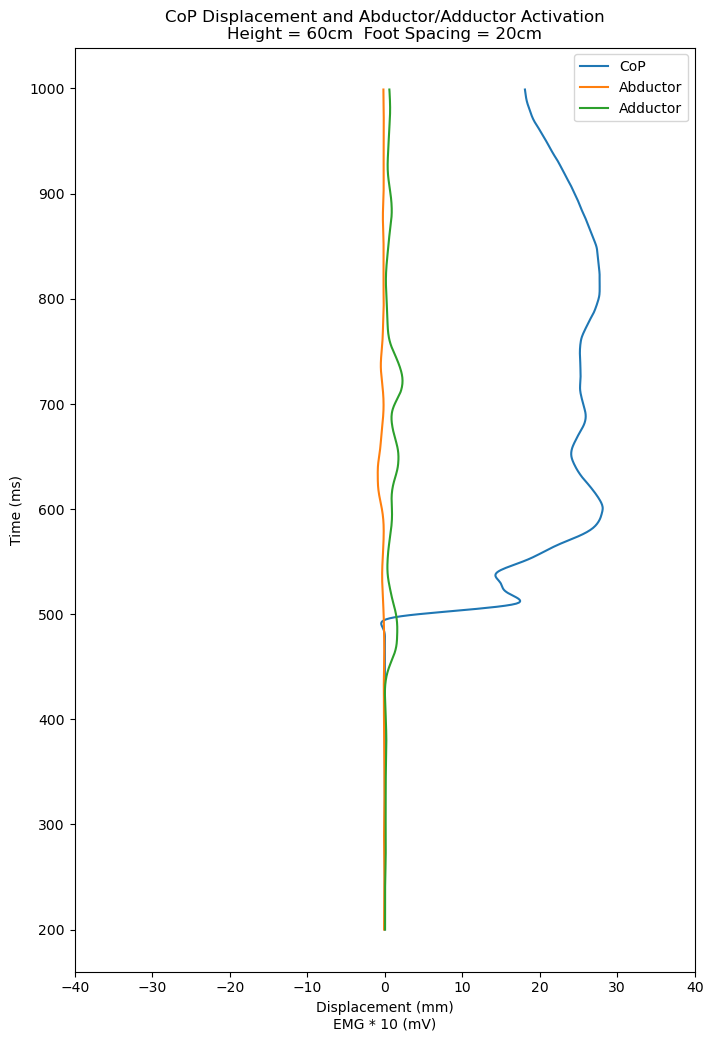

In [16]:
# filter data for height = 60 and spacing = 20
height = 60
spacing = 20
trial = 2
filt1 = (all_trials.height == height) & (all_trials.spacing == spacing) & (all_trials.trial == trial)

# plot CoP and abductor/adductor EMG on same plot
plt.figure(figsize=(8, 12))
filtered_cop = bw_filter(all_trials.loc[filt1].cop_y_displacement.values, 50, 1000)
y = np.linspace(0, len(filtered_cop) - 1, len(filtered_cop))
plt.plot(-filtered_cop[200:1000], y[200:1000], label="CoP")
filtered_abd = bw_filter(all_trials.loc[filt1].abductor_right.values, 15, 1000)
plt.plot(filtered_abd[200:1000] * -10, y[200:1000], label="Abductor")
filtered_add = bw_filter(all_trials.loc[filt1].adductor_right.values, 15, 1000)
plt.plot(filtered_add[200:1000] * 10, y[200:1000], label="Adductor")
plt.xlabel("Displacement (mm)\nEMG * 10 (mV)")
plt.ylabel("Time (ms)")
plt.xlim(-40, 40)
plt.title("CoP Displacement and Abductor/Adductor Activation\nHeight = {}cm  Foot Spacing = {}cm".format(height, spacing))
plt.legend()
plt.show();

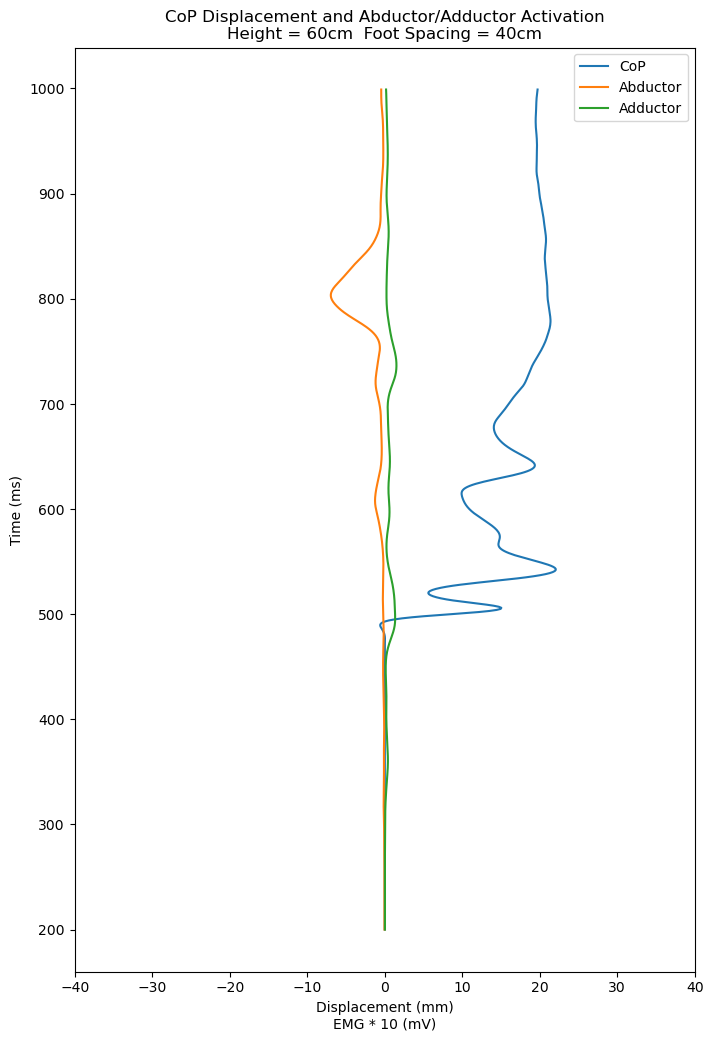

In [17]:
# filter data for height = 60 and spacing = 40
height = 60
spacing = 40
trial = 2
filt1 = (all_trials.height == height) & (all_trials.spacing == spacing) & (all_trials.trial == trial)

# plot CoP and abductor/adductor EMG on same plot
plt.figure(figsize=(8, 12))
filtered_cop = bw_filter(all_trials.loc[filt1].cop_y_displacement.values, 50, 1000)
y = np.linspace(0, len(filtered_cop) - 1, len(filtered_cop))
plt.plot(-filtered_cop[200:1000], y[200:1000], label="CoP")
filtered_abd = bw_filter(all_trials.loc[filt1].abductor_right.values, 15, 1000)
plt.plot(filtered_abd[200:1000] * -10, y[200:1000], label="Abductor")
filtered_add = bw_filter(all_trials.loc[filt1].adductor_right.values, 15, 1000)
plt.plot(filtered_add[200:1000] * 10, y[200:1000], label="Adductor")
plt.xlabel("Displacement (mm)\nEMG * 10 (mV)")
plt.ylabel("Time (ms)")
plt.xlim(-40, 40)
plt.title("CoP Displacement and Abductor/Adductor Activation\nHeight = {}cm  Foot Spacing = {}cm".format(height, spacing))
plt.legend()
plt.show();

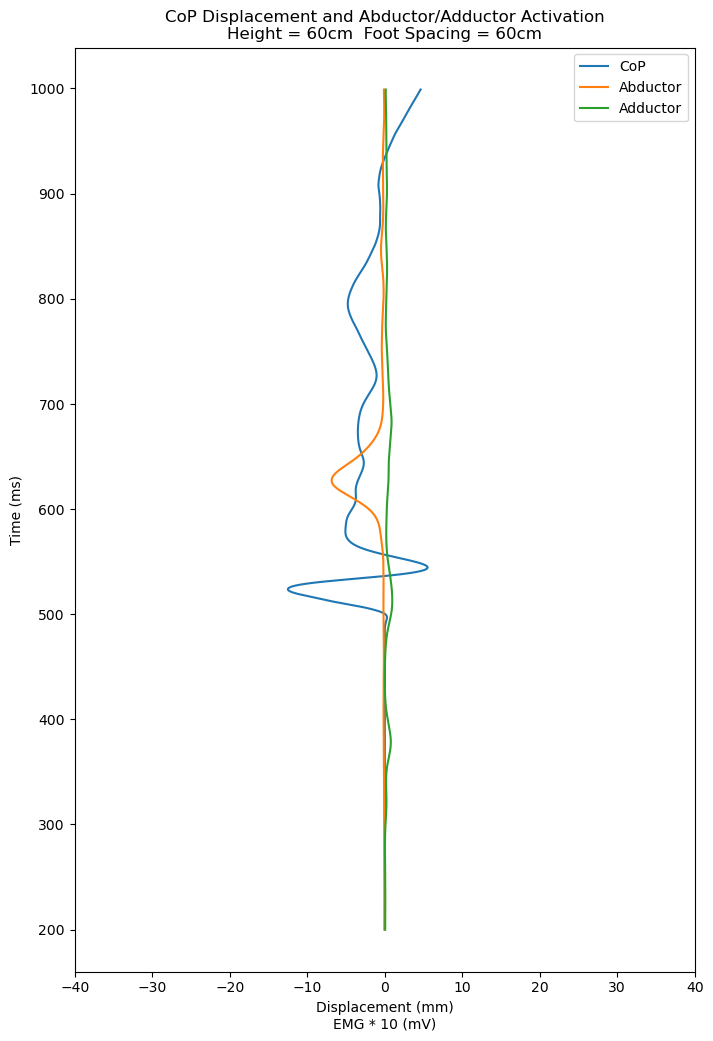

In [18]:
# filter data for height = 60 and spacing = 60
height = 60
spacing = 60
trial = 2
filt1 = (all_trials.height == height) & (all_trials.spacing == spacing) & (all_trials.trial == trial)

# plot CoP and abductor/adductor EMG on same plot
plt.figure(figsize=(8, 12))
filtered_cop = bw_filter(all_trials.loc[filt1].cop_y_displacement.values, 50, 1000)
y = np.linspace(0, len(filtered_cop) - 1, len(filtered_cop))
plt.plot(-filtered_cop[200:1000], y[200:1000], label="CoP")
filtered_abd = bw_filter(all_trials.loc[filt1].abductor_right.values, 15, 1000)
plt.plot(filtered_abd[200:1000] * -10, y[200:1000], label="Abductor")
filtered_add = bw_filter(all_trials.loc[filt1].adductor_right.values, 15, 1000)
plt.plot(filtered_add[200:1000] * 10, y[200:1000], label="Adductor")
plt.xlabel("Displacement (mm)\nEMG * 10 (mV)")
plt.ylabel("Time (ms)")
plt.xlim(-40, 40)
plt.title("CoP Displacement and Abductor/Adductor Activation\nHeight = {}cm  Foot Spacing = {}cm".format(height, spacing))
plt.legend()
plt.show();

Knee Angles

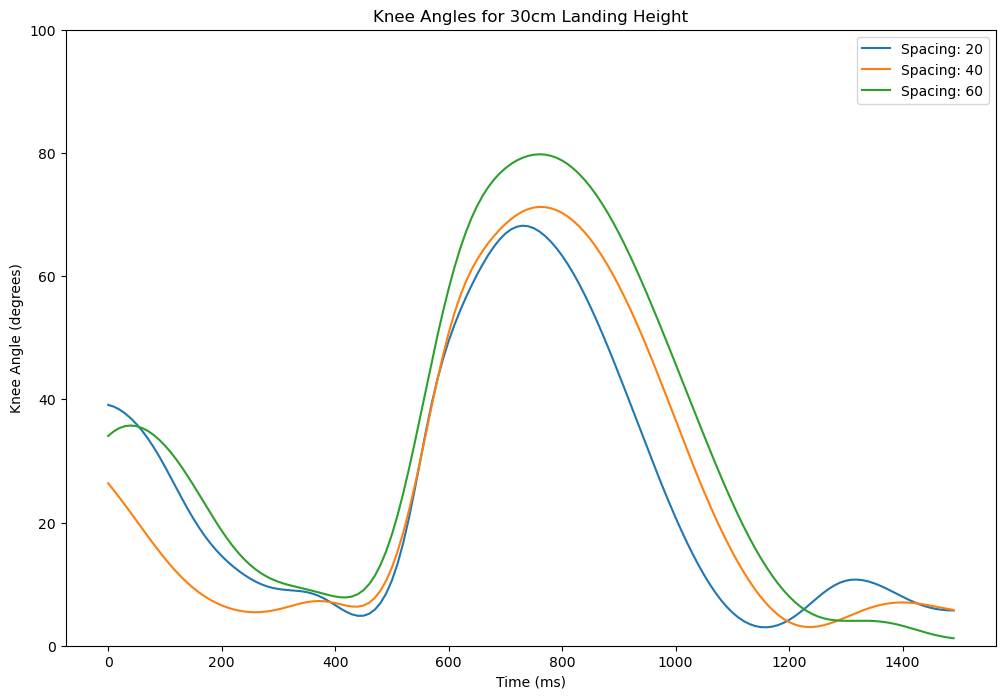

In [19]:
# Knee angles for height = 30
# filter data for spacing = 20
height = 30
spacing = 20
trial = 3
filt1 = (all_trials.height == height) & (all_trials.spacing == spacing) & (all_trials.trial == trial)

# filter data for spacing = 40
height = 30
spacing = 40
trial = 3
filt2 = (all_trials.height == height) & (all_trials.spacing == spacing) & (all_trials.trial == trial)

# filter data for spacing = 60
height = 30
spacing = 60
trial = 3
filt3 = (all_trials.height == height) & (all_trials.spacing == spacing) & (all_trials.trial == trial)

# plot all samples on same plot
plt.figure(figsize=(12, 8))
plt.plot(all_trials.loc[filt1].knee_angle_right.reset_index(drop=True)[::10], label="Spacing: 20")
plt.plot(all_trials.loc[filt2].knee_angle_right.reset_index(drop=True)[::10], label="Spacing: 40")
plt.plot(all_trials.loc[filt3].knee_angle_right.reset_index(drop=True)[::10], label="Spacing: 60")
plt.xlabel("Time (ms)")
plt.ylabel("Knee Angle (degrees)")
plt.ylim(0, 100)
plt.title("Knee Angles for 30cm Landing Height")
plt.legend()
plt.show();

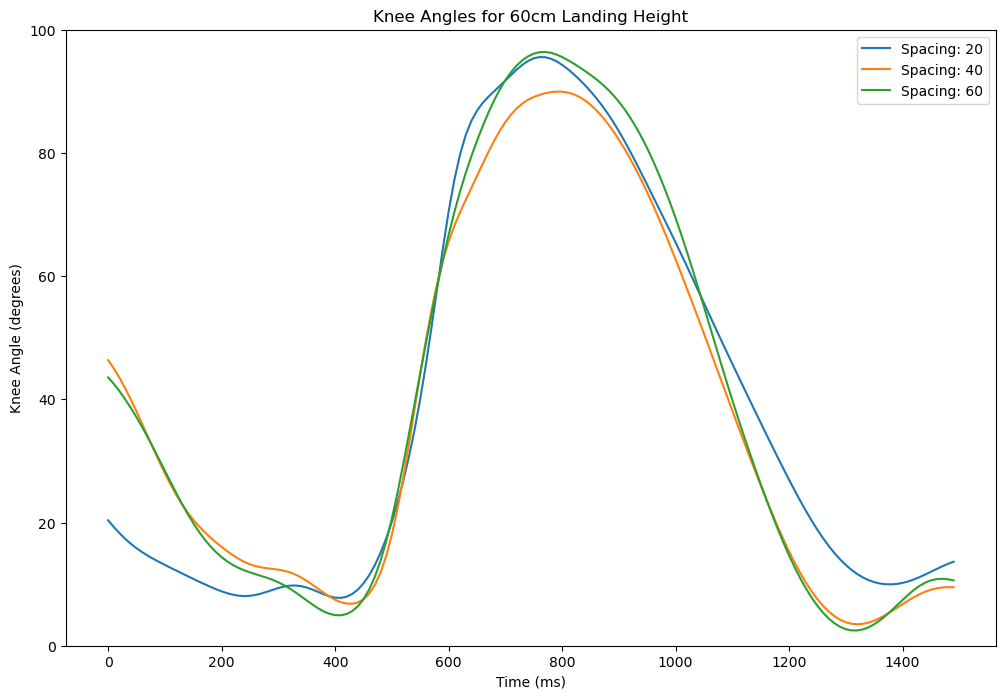

In [20]:
# Knee angles for height = 60
# filter data for spacing = 20
height = 60
spacing = 20
trial = 2
filt1 = (all_trials.height == height) & (all_trials.spacing == spacing) & (all_trials.trial == trial)

# filter data for spacing = 40
height = 60
spacing = 40
trial = 2
filt2 = (all_trials.height == height) & (all_trials.spacing == spacing) & (all_trials.trial == trial)

# filter data for spacing = 60
height = 60
spacing = 60
trial = 2
filt3 = (all_trials.height == height) & (all_trials.spacing == spacing) & (all_trials.trial == trial)

# plot all samples on same plot
plt.figure(figsize=(12, 8))
plt.plot(all_trials.loc[filt1].knee_angle_right.reset_index(drop=True)[::10], label="Spacing: 20")
plt.plot(all_trials.loc[filt2].knee_angle_right.reset_index(drop=True)[::10], label="Spacing: 40")
plt.plot(all_trials.loc[filt3].knee_angle_right.reset_index(drop=True)[::10], label="Spacing: 60")
plt.xlabel("Time (ms)")
plt.ylabel("Knee Angle (degrees)")
plt.ylim(0, 100)
plt.title("Knee Angles for 60cm Landing Height")
plt.legend()
plt.show();

GRFs and Knee Angles

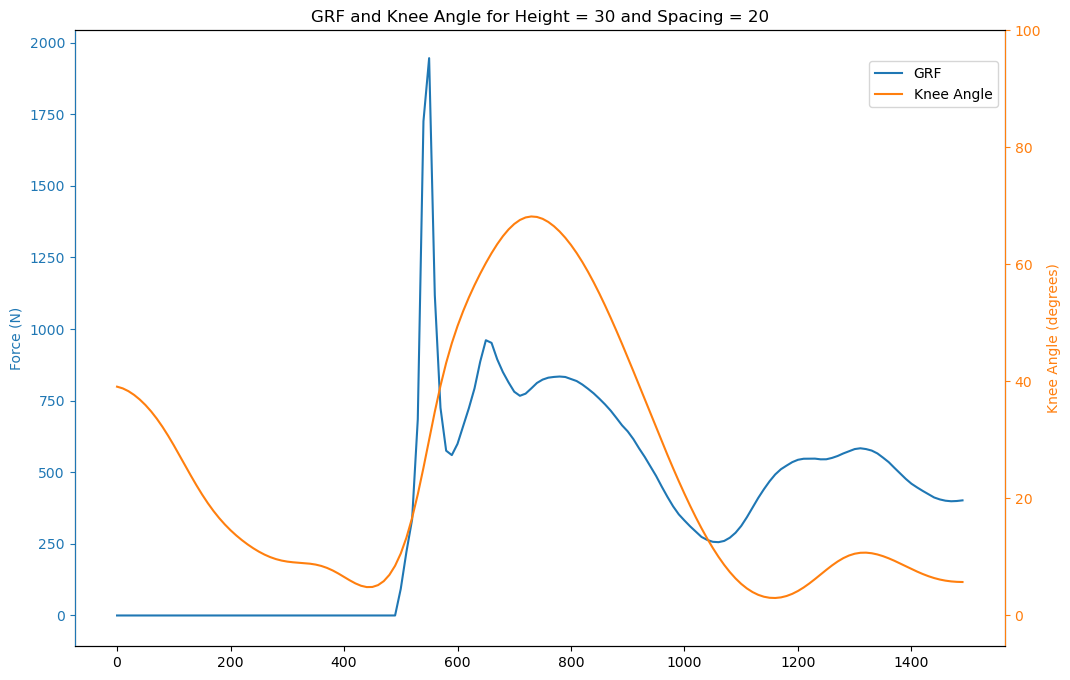

In [21]:
# filter data for height = 30 and spacing = 20
height = 30
spacing = 20
trial = 3
filt1 = (all_trials.height == height) & (all_trials.spacing == spacing) & (all_trials.trial == trial)

fig, ax1 = plt.subplots(figsize=(12, 8))

ax1.plot(all_trials.loc[filt1].fz_right.reset_index(drop=True)[::10], color='C0')
ax1.set_ylabel("Force (N)", color='C0')
ax1.tick_params(axis='y', color='C0', labelcolor='C0')
ax1.set_title("GRF and Knee Angle for Height = {} and Spacing = {}".format(height, spacing))

ax2 = ax1.twinx()
ax2.plot(all_trials.loc[filt1].knee_angle_right.reset_index(drop=True)[::10], color='C1')
ax2.set_ylabel("Knee Angle (degrees)", color='C1')
ax2.set_ylim(0, 100)
ax2.tick_params(axis='y', color='C1', labelcolor='C1')
ax2.spines['right'].set_color('C1')
ax2.spines['left'].set_color('C0')

fig.legend(["GRF", "Knee Angle"], bbox_to_anchor=(0.9, 0.85))

org1 = 0.0
org2 = 0.0
pos = 0.05
align.yaxes(ax1, org1, ax2, org2, pos)

plt.show();

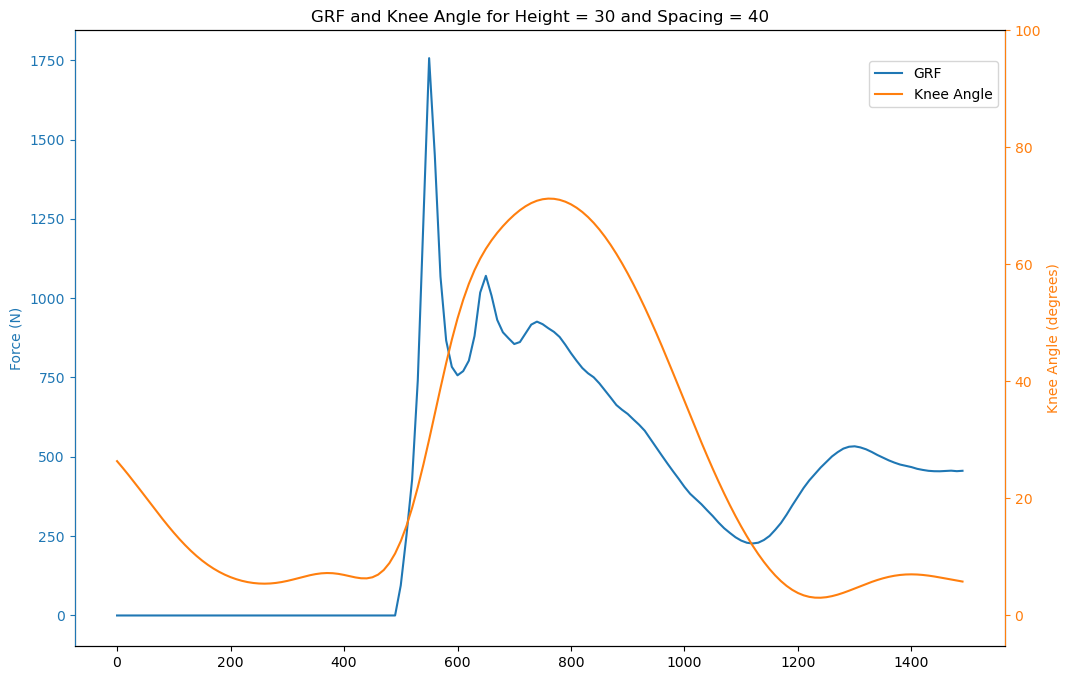

In [22]:
# filter data for height = 30 and spacing = 40
height = 30
spacing = 40
trial = 3
filt1 = (all_trials.height == height) & (all_trials.spacing == spacing) & (all_trials.trial == trial)

fig, ax1 = plt.subplots(figsize=(12, 8))

ax1.plot(all_trials.loc[filt1].fz_right.reset_index(drop=True)[::10], color='C0')
ax1.set_ylabel("Force (N)", color='C0')
ax1.tick_params(axis='y', color='C0', labelcolor='C0')
ax1.set_title("GRF and Knee Angle for Height = {} and Spacing = {}".format(height, spacing))

ax2 = ax1.twinx()
ax2.plot(all_trials.loc[filt1].knee_angle_right.reset_index(drop=True)[::10], color='C1')
ax2.set_ylabel("Knee Angle (degrees)", color='C1')
ax2.set_ylim(0, 100)
ax2.tick_params(axis='y', color='C1', labelcolor='C1')
ax2.spines['right'].set_color('C1')
ax2.spines['left'].set_color('C0')

fig.legend(["GRF", "Knee Angle"], bbox_to_anchor=(0.9, 0.85))

org1 = 0.0
org2 = 0.0
pos = 0.05
align.yaxes(ax1, org1, ax2, org2, pos)

plt.show();

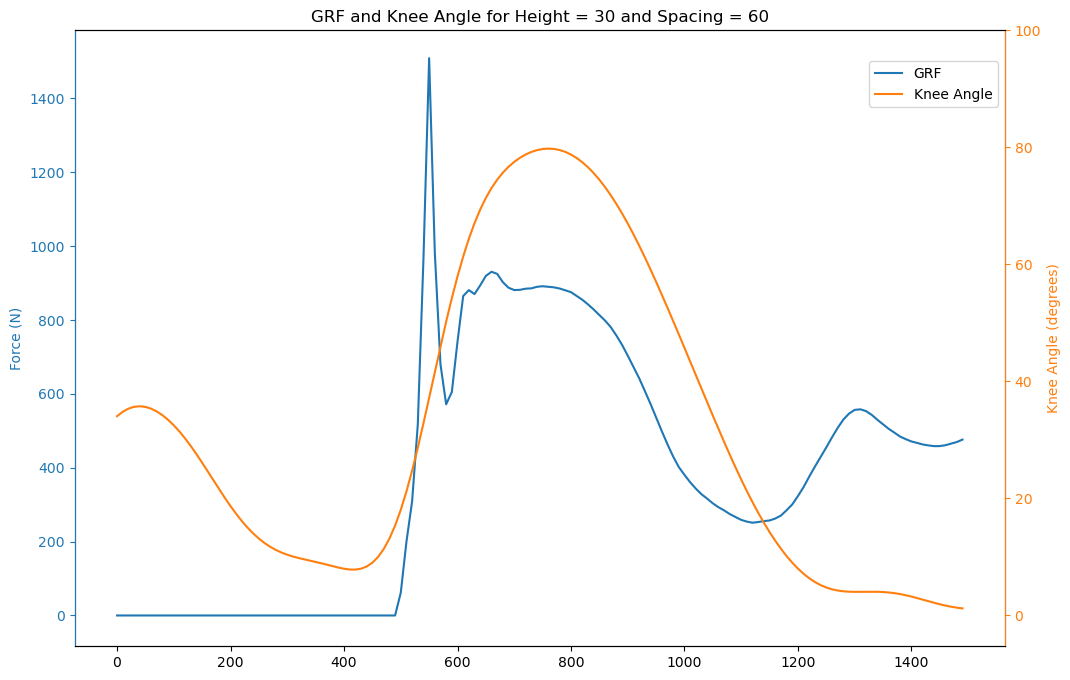

In [23]:
# filter data for height = 30 and spacing = 60
height = 30
spacing = 60
trial = 3
filt1 = (all_trials.height == height) & (all_trials.spacing == spacing) & (all_trials.trial == trial)

fig, ax1 = plt.subplots(figsize=(12, 8))

ax1.plot(all_trials.loc[filt1].fz_right.reset_index(drop=True)[::10], color='C0')
ax1.set_ylabel("Force (N)", color='C0')
ax1.tick_params(axis='y', color='C0', labelcolor='C0')

ax1.set_title("GRF and Knee Angle for Height = {} and Spacing = {}".format(height, spacing))

ax2 = ax1.twinx()
ax2.plot(all_trials.loc[filt1].knee_angle_right.reset_index(drop=True)[::10], color='C1')
ax2.set_ylabel("Knee Angle (degrees)", color='C1')
ax2.set_ylim(0, 100)
ax2.tick_params(axis='y', color='C1', labelcolor='C1')
ax2.spines['right'].set_color('C1')
ax2.spines['left'].set_color('C0')

fig.legend(["GRF", "Knee Angle"], bbox_to_anchor=(0.9, 0.85))

org1 = 0.0
org2 = 0.0
pos = 0.05
align.yaxes(ax1, org1, ax2, org2, pos)

plt.show();

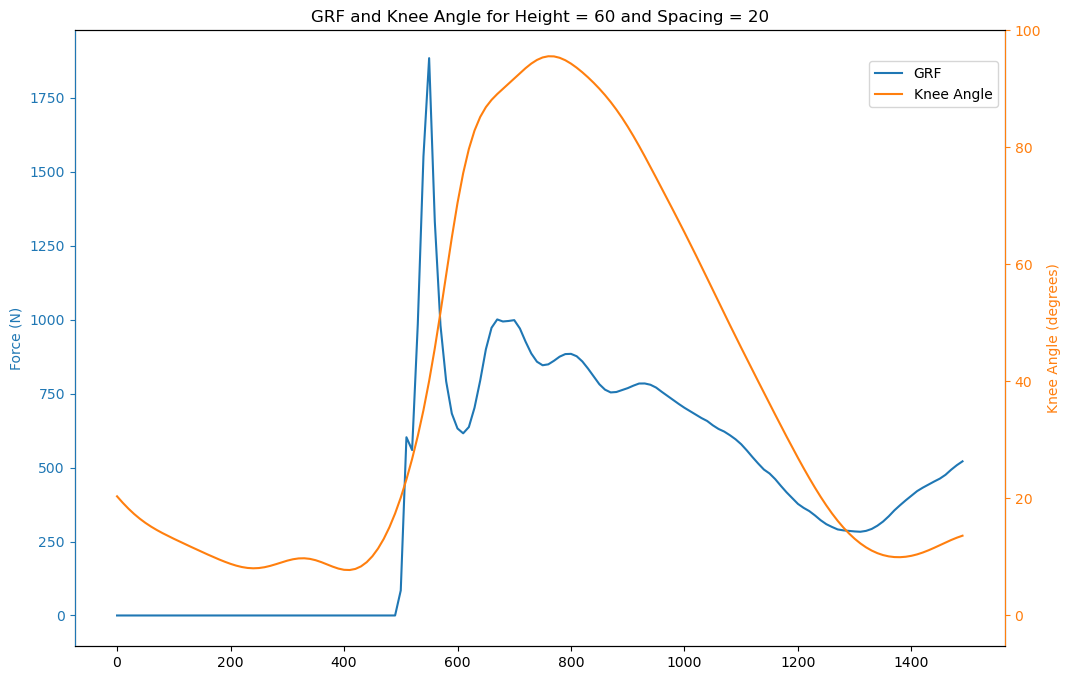

In [24]:
# filter data for height = 60 and spacing = 20
height = 60
spacing = 20
trial = 2
filt1 = (all_trials.height == height) & (all_trials.spacing == spacing) & (all_trials.trial == trial)

fig, ax1 = plt.subplots(figsize=(12, 8))

ax1.plot(all_trials.loc[filt1].fz_right.reset_index(drop=True)[::10], color='C0')
ax1.set_ylabel("Force (N)", color='C0')
ax1.tick_params(axis='y', color='C0', labelcolor='C0')

ax1.set_title("GRF and Knee Angle for Height = {} and Spacing = {}".format(height, spacing))

ax2 = ax1.twinx()
ax2.plot(all_trials.loc[filt1].knee_angle_right.reset_index(drop=True)[::10], color='C1')
ax2.set_ylabel("Knee Angle (degrees)", color='C1')
ax2.set_ylim(0, 100)
ax2.tick_params(axis='y', color='C1', labelcolor='C1')
ax2.spines['right'].set_color('C1')
ax2.spines['left'].set_color('C0')

fig.legend(["GRF", "Knee Angle"], bbox_to_anchor=(0.9, 0.85))

org1 = 0.0
org2 = 0.0
pos = 0.05
align.yaxes(ax1, org1, ax2, org2, pos)

plt.show();

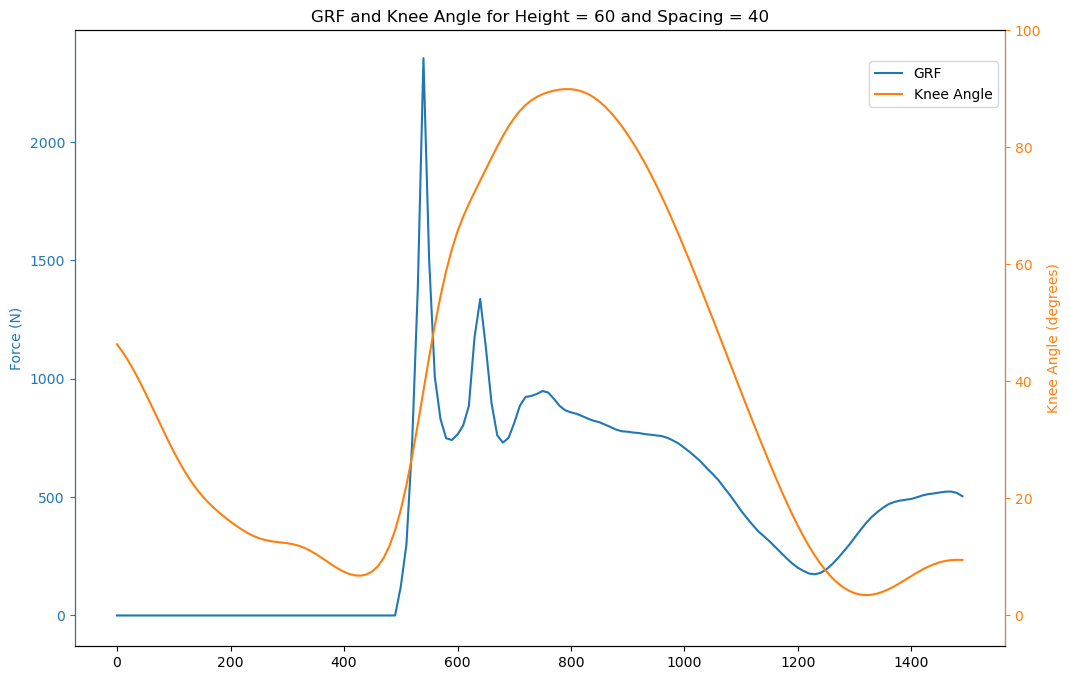

In [25]:
# filter data for height = 60 and spacing = 40
height = 60
spacing = 40
trial = 2
filt1 = (all_trials.height == height) & (all_trials.spacing == spacing) & (all_trials.trial == trial)

fig, ax1 = plt.subplots(figsize=(12, 8))

ax1.plot(all_trials.loc[filt1].fz_right.reset_index(drop=True)[::10], color='C0')
ax1.set_ylabel("Force (N)", color='C0')
ax1.tick_params(axis='y', color='C0', labelcolor='C0')

ax1.set_title("GRF and Knee Angle for Height = {} and Spacing = {}".format(height, spacing))

ax2 = ax1.twinx()
ax2.plot(all_trials.loc[filt1].knee_angle_right.reset_index(drop=True)[::10], color='C1')
ax2.set_ylabel("Knee Angle (degrees)", color='C1')
ax2.set_ylim(0, 100)
ax2.tick_params(axis='y', color='C1', labelcolor='C1')
ax2.spines['right'].set_color('C1')
ax2.spines['left'].set_color('C0')

fig.legend(["GRF", "Knee Angle"], bbox_to_anchor=(0.9, 0.85))

org1 = 0.0
org2 = 0.0
pos = 0.05
align.yaxes(ax1, org1, ax2, org2, pos)

plt.show();

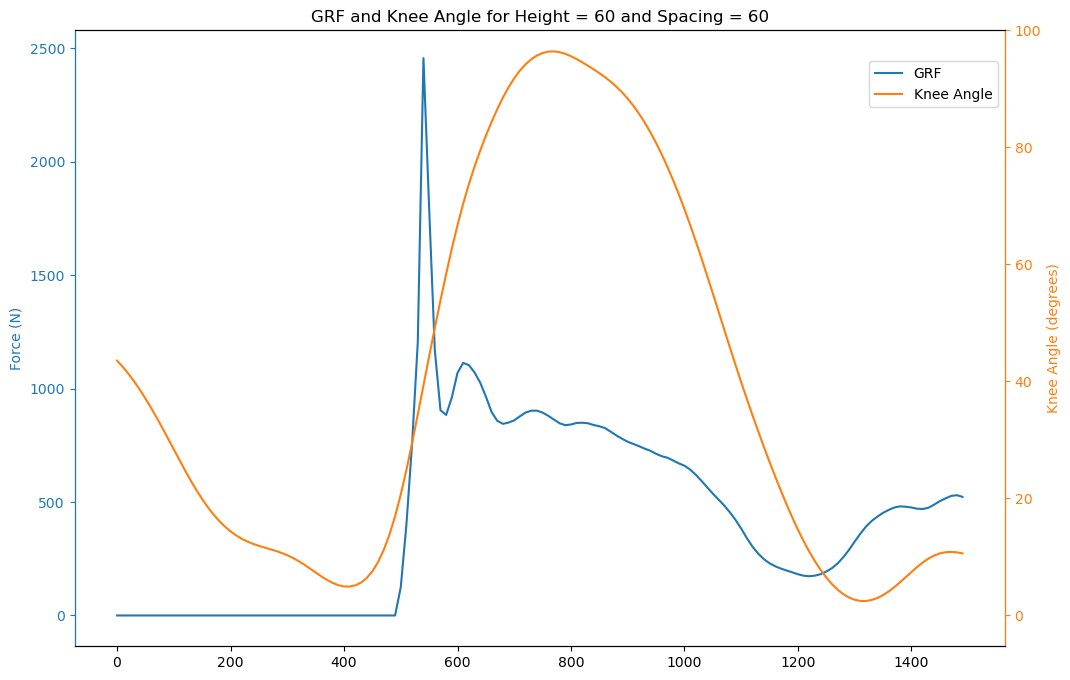

In [26]:
# filter data for height = 60 and spacing = 60
height = 60
spacing = 60
trial = 2
filt1 = (all_trials.height == height) & (all_trials.spacing == spacing) & (all_trials.trial == trial)

fig, ax1 = plt.subplots(figsize=(12, 8))

ax1.plot(all_trials.loc[filt1].fz_right.reset_index(drop=True)[::10], color='C0')
ax1.set_ylabel("Force (N)", color='C0')
ax1.tick_params(axis='y', color='C0', labelcolor='C0')

ax1.set_title("GRF and Knee Angle for Height = {} and Spacing = {}".format(height, spacing))

ax2 = ax1.twinx()
ax2.plot(all_trials.loc[filt1].knee_angle_right.reset_index(drop=True)[::10], color='C1')
ax2.set_ylabel("Knee Angle (degrees)", color='C1')
ax2.set_ylim(0, 100)
ax2.tick_params(axis='y', color='C1', labelcolor='C1')
ax2.spines['right'].set_color('C1')
ax2.spines['left'].set_color('C0')

fig.legend(["GRF", "Knee Angle"], bbox_to_anchor=(0.9, 0.85))

org1 = 0.0
org2 = 0.0
pos = 0.05
align.yaxes(ax1, org1, ax2, org2, pos)

plt.show();